In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn

from augmentation import AddGaussianNoise
from dataset import get_dataloaders_unsupervised
from train_segmentation import transfer_knowledge
from unet import Unet, SkipType

In [2]:
device = 'cuda'
# model = Unet(layers=[8, 16, 32, 64, 128], output_channels=1).to(device)

# model.load_state_dict(torch.load('learned_models/autoencoder/1e-4_50epochs_invert.pt', map_location=device))
# model.eval()

_, dataloader_train, _, dataloader_test = get_dataloaders_unsupervised(image_folder='projs', augmentations=AddGaussianNoise(std=0.5), workers=1)

def plot_single(img, dict_path, skip=SkipType.SKIP):
    model = Unet(layers=[8, 16, 32, 64, 128], output_channels=1, skip=skip).to(device)

    model.load_state_dict(torch.load(dict_path, map_location=device))

    with torch.no_grad():
        fig, (ax1, ax2) = plt.subplots(1, 2)

        initial = img.cpu().numpy().squeeze()
        processed = model(img).cpu().numpy().squeeze()

        # print(initial.shape, processed.shape)

        ax1.imshow(initial)
        ax2.imshow(processed)
        plt.show()

In [3]:
samples = list(itertools.islice(dataloader_train, 5))

In [4]:
def plot_five(dict_path, skip=SkipType.SKIP):
    for img in samples:
        if isinstance(img, list):
            img, augmented = img
        else:
            augmented = img

        # img = 1. - img

        plot_single(augmented.to(device), dict_path, skip)

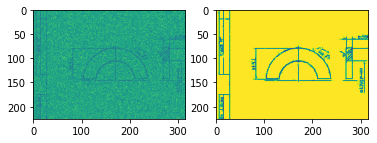

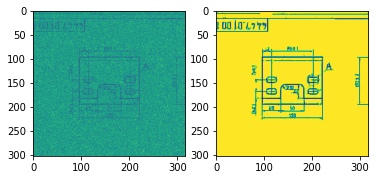

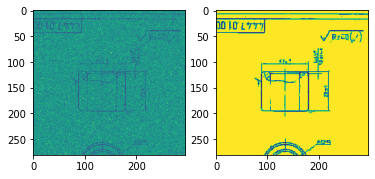

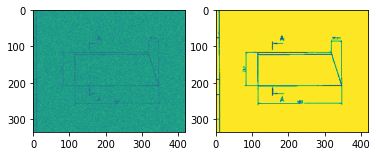

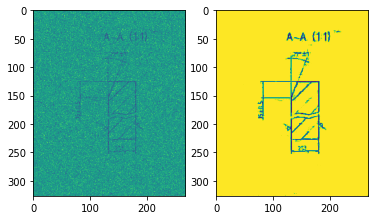

In [5]:
plot_five('learned_models/autoencoder/1e-4_gauss_05_10epochs.pt')

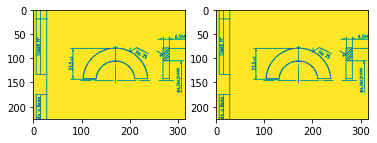

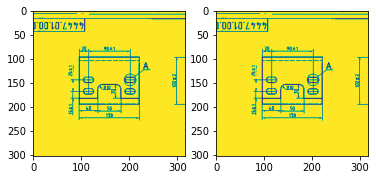

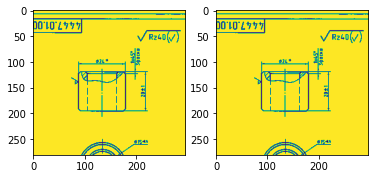

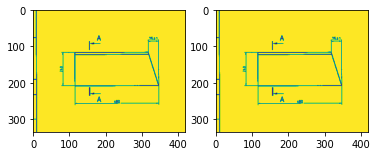

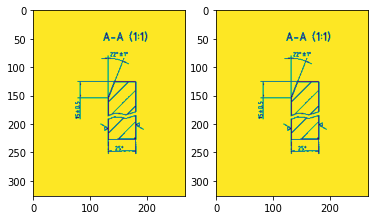

In [6]:
plot_five('learned_models/03_05/autoencoder/1e-4_50epochs.pt')

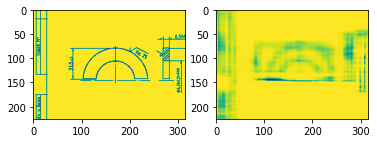

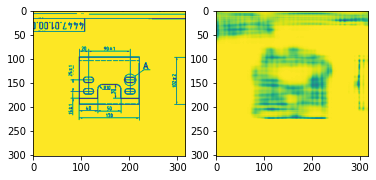

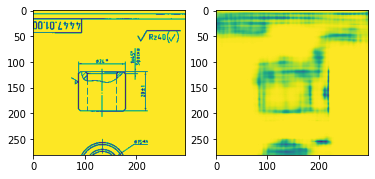

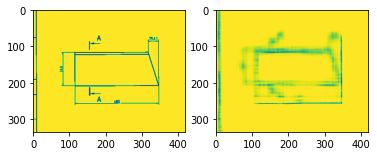

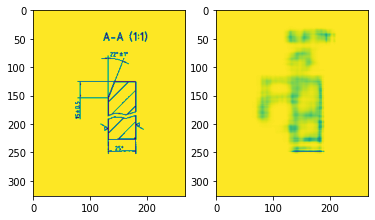

In [7]:
plot_five('learned_models/03_05/autoencoder/1e-4_50epochs_no_skip.pt', SkipType.NO_SKIP)

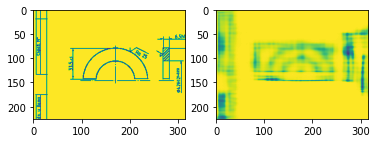

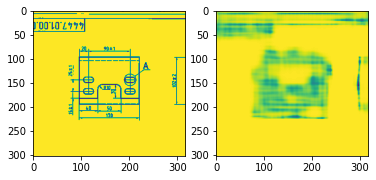

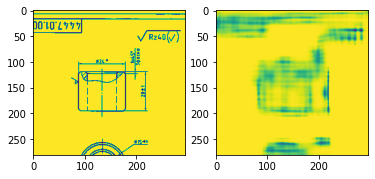

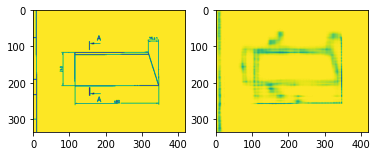

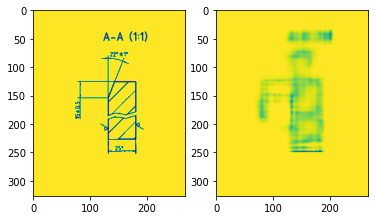

In [8]:
plot_five('learned_models/03_05/autoencoder/1e-4_50epochs_zero_skip.pt')

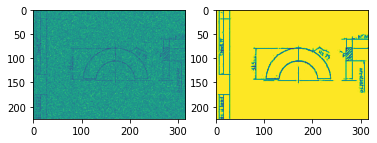

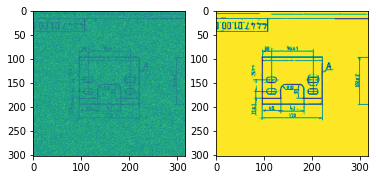

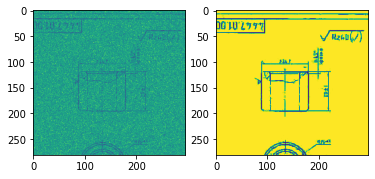

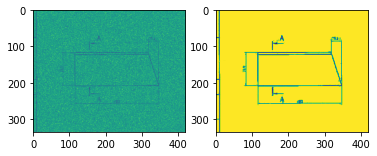

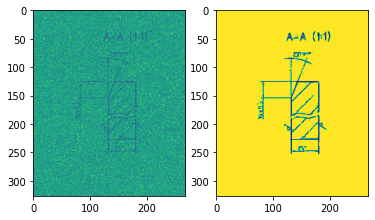

In [33]:
plot_five('learned_models/autoencoder/50epochs_1e-4_gauss_05.pt')

In [34]:
def test_on_cats_and_blueprints(title, model_path, skip=SkipType.SKIP, cat=True, no_sigmoid=False):
    # import matplotlib.pyplot as plt
    # from PIL import Image
    # import numpy as np
    # from pathlib import Path
    # import torch.nn as nn
    # from unet import Unet
    # from train_segmentation import transfer_knowledge

    model = Unet(layers=[8, 16, 32, 64, 128], output_channels=1, skip=skip)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    # transfer_knowledge(model, model_path)
    dataset_train, dataloader_train, dataset_test, dataloader_test = get_dataloaders_unsupervised(dpi=50)

    criterion = nn.MSELoss()

    model.eval()
    if not cat:
        img = next(iter(dataloader_train))
    else:
        img = torch.Tensor(np.array(Image.open('E:/acady/Desktop/83211.jpg').convert('L')).reshape([1, 1, 173, -1]))
    img_decoded = model.forward_vars(img / 255)['res']
    if not no_sigmoid:
        img_decoded = torch.sigmoid(img_decoded)

    # print(img.shape)
    # print(img_decoded.shape)
    loss = criterion(img, img_decoded)
    # print(loss.item())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 20])
    a1 = ax1.imshow(img.squeeze())
    a2 = ax2.imshow(img_decoded.cpu().detach().numpy().squeeze())
    # fig.colorbar(a2, ax=ax2)
    # fig.colorbar(a1, ax=ax1)

    # img_decoded = img_decoded.cpu().detach().numpy().squeeze()
    # img_decoded = img_decoded.transpose(1, 2, 0)  # np.swapaxes(img_decoded, 0, 2)
    # img_decoded = np.uint8((img_decoded + np.min(img_decoded)) / (np.max(img_decoded) + np.min(img_decoded)) * 255)
    # Image.fromarray(img_decoded, 'RGB').show()

    # fig.colorbar(a, ax=fig)
    # fig.suptitle(f'{title}\nLoss: {loss}', fontsize=30)
    plt.show()
    # train_as_autoencoder(model, dataloader_train)

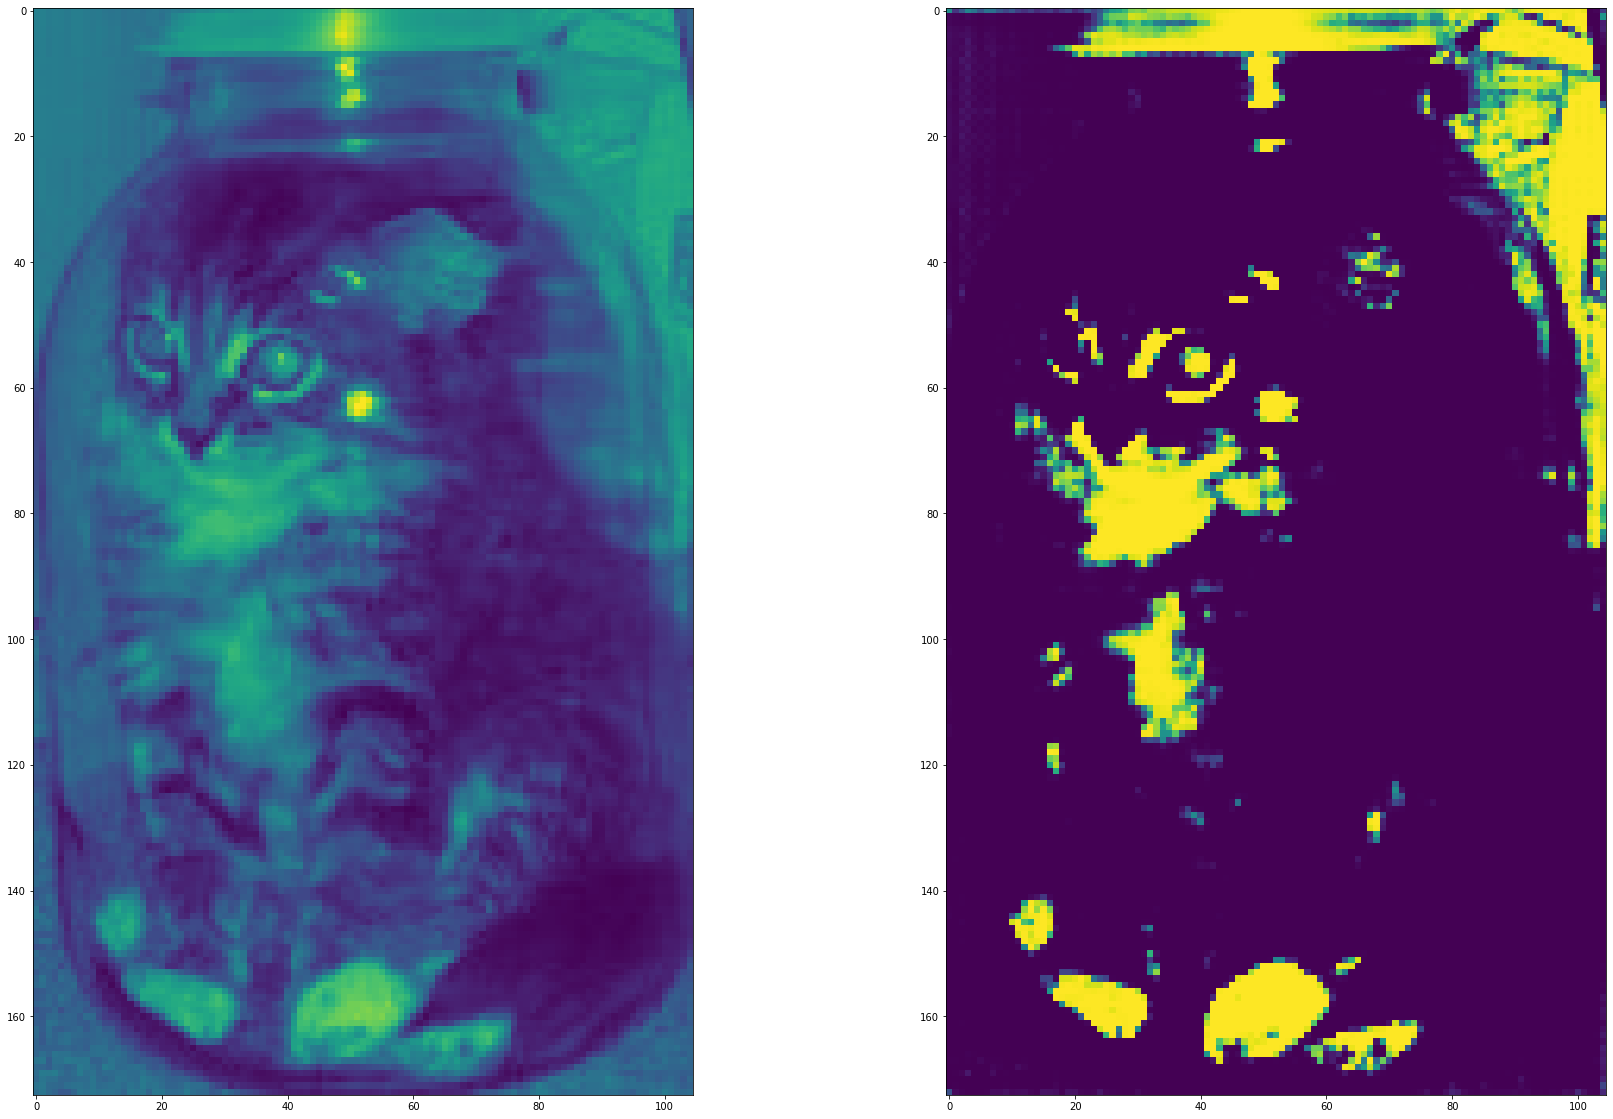

In [20]:
test_on_cats_and_blueprints('skips with sigmoid', Path() / 'learned_models' / '03_05' / 'autoencoder'/ '1e-4_50epochs.pt')

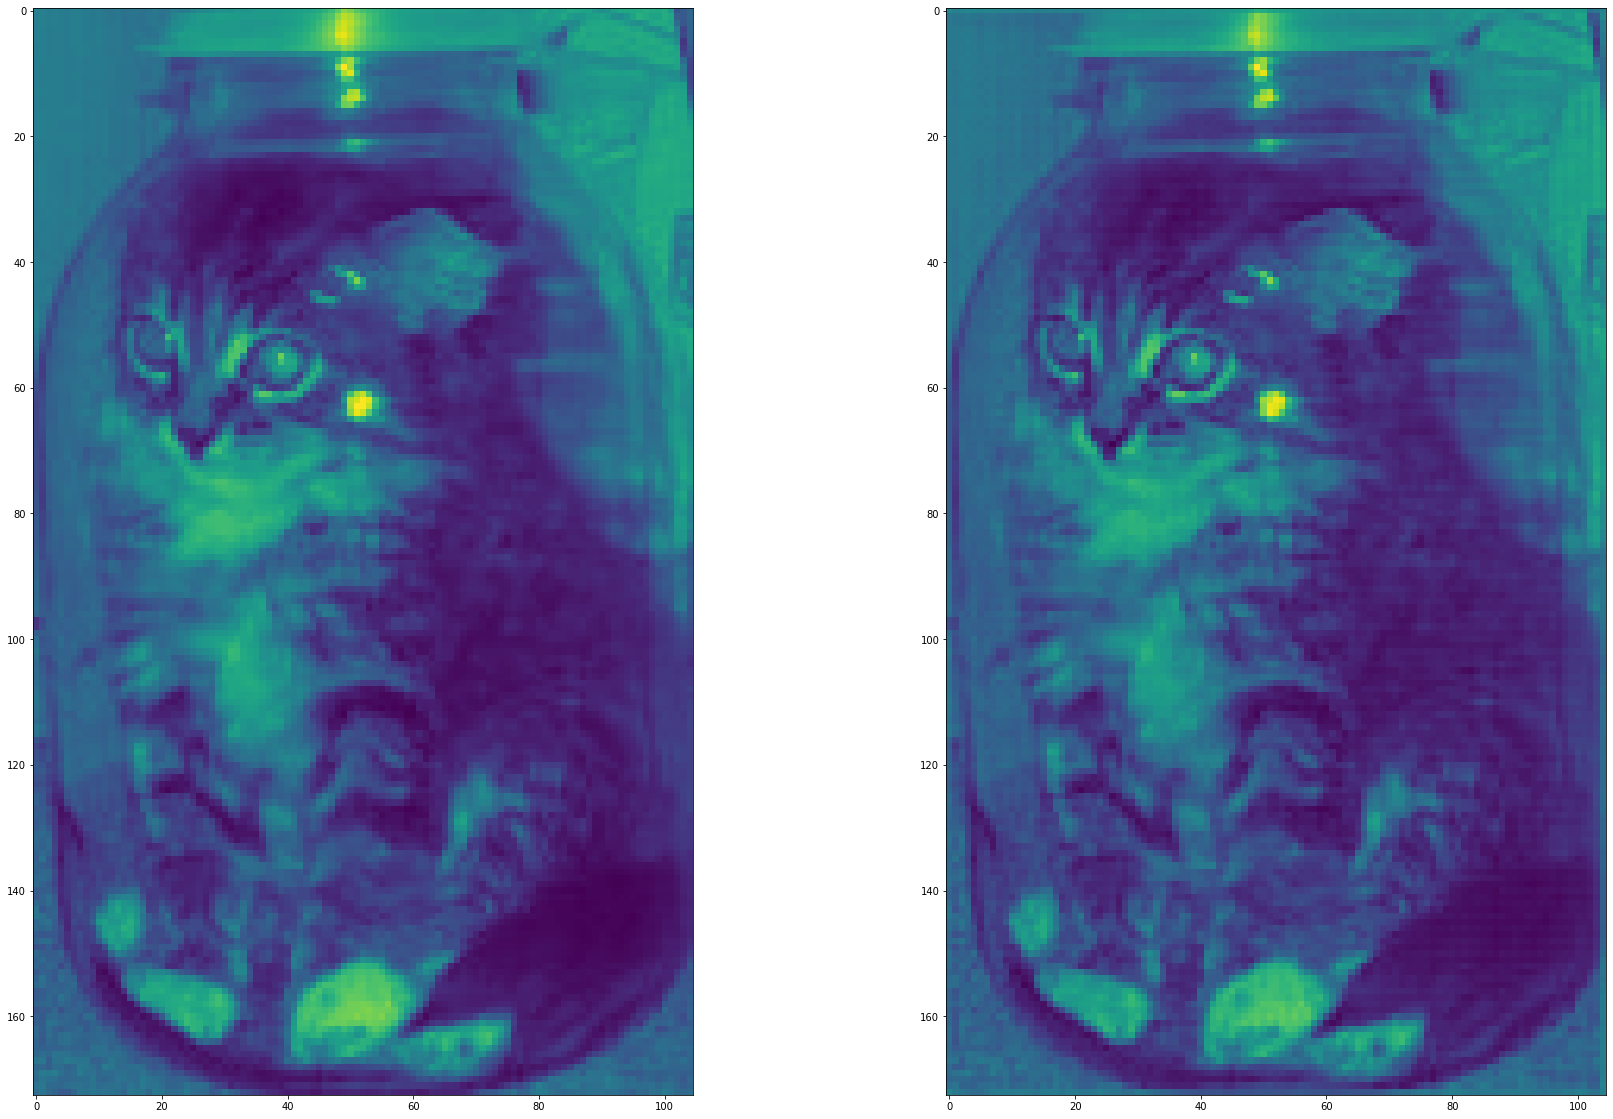

In [21]:
test_on_cats_and_blueprints('skips no sigmoid', Path() / 'learned_models' / '03_05' / 'autoencoder'/ '1e-4_50epochs.pt', no_sigmoid=True)

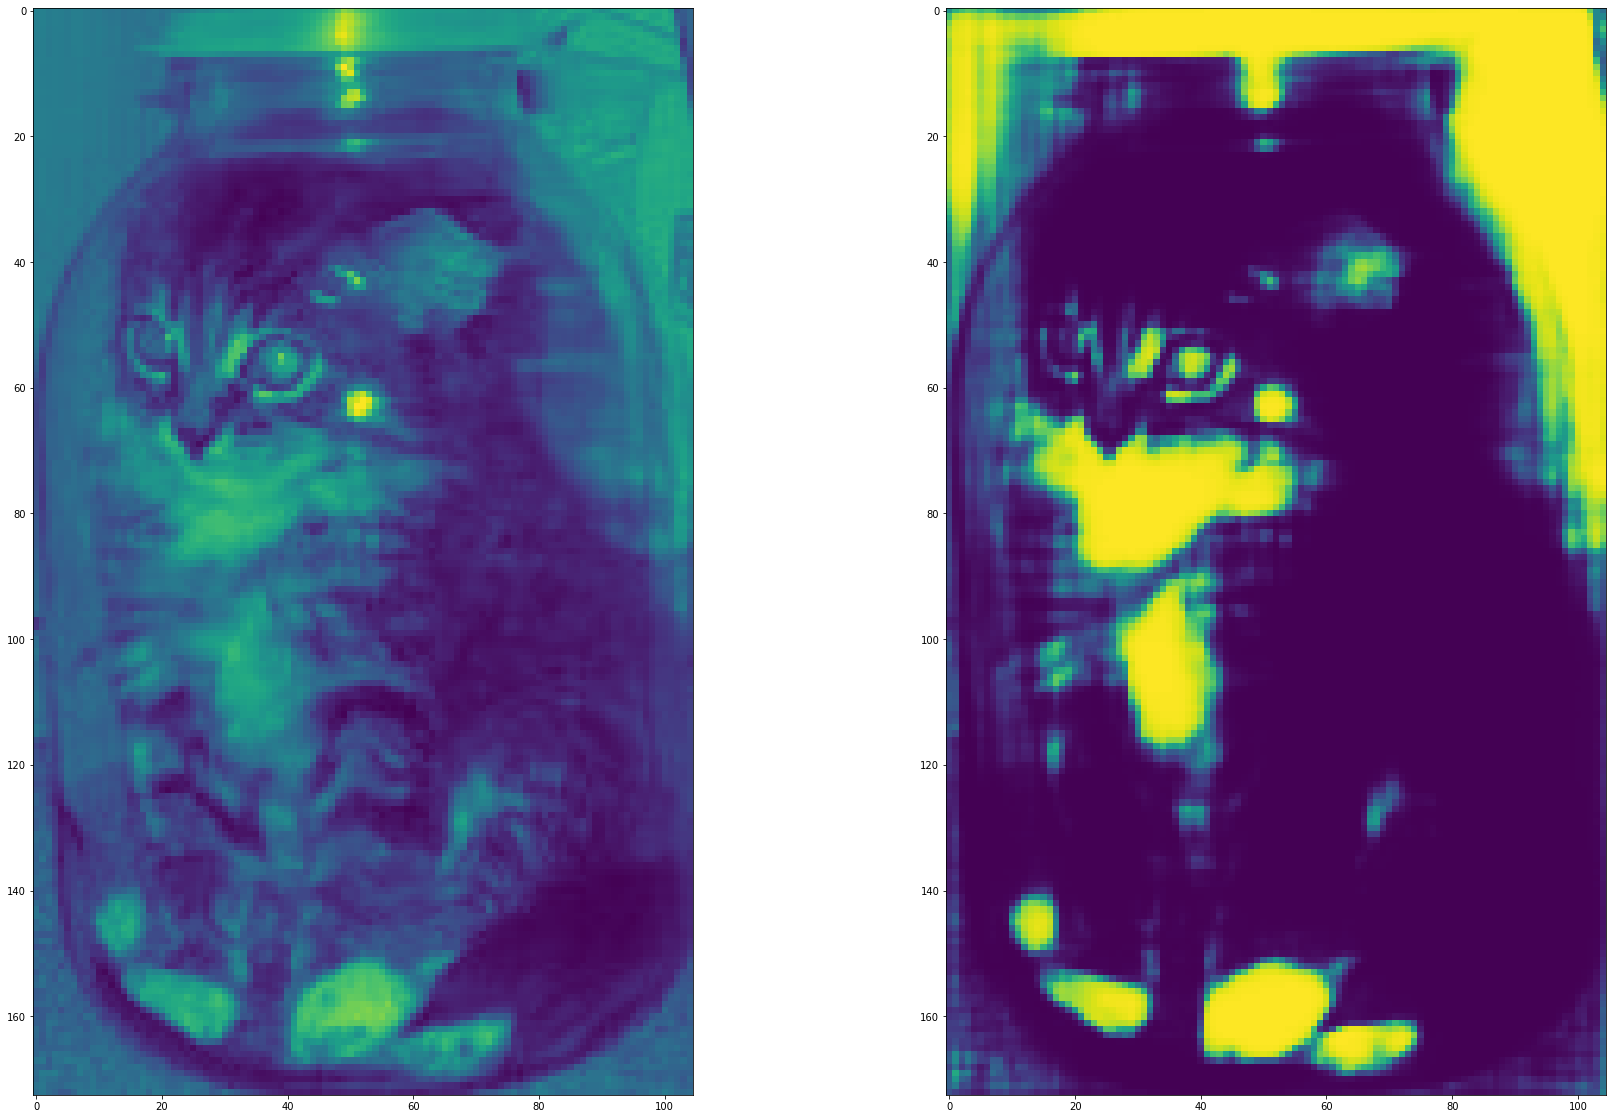

In [35]:
test_on_cats_and_blueprints('skips with sigmoid gaussian noise', Path() / 'learned_models' / 'autoencoder'/ '50epochs_1e-4_gauss_05.pt')

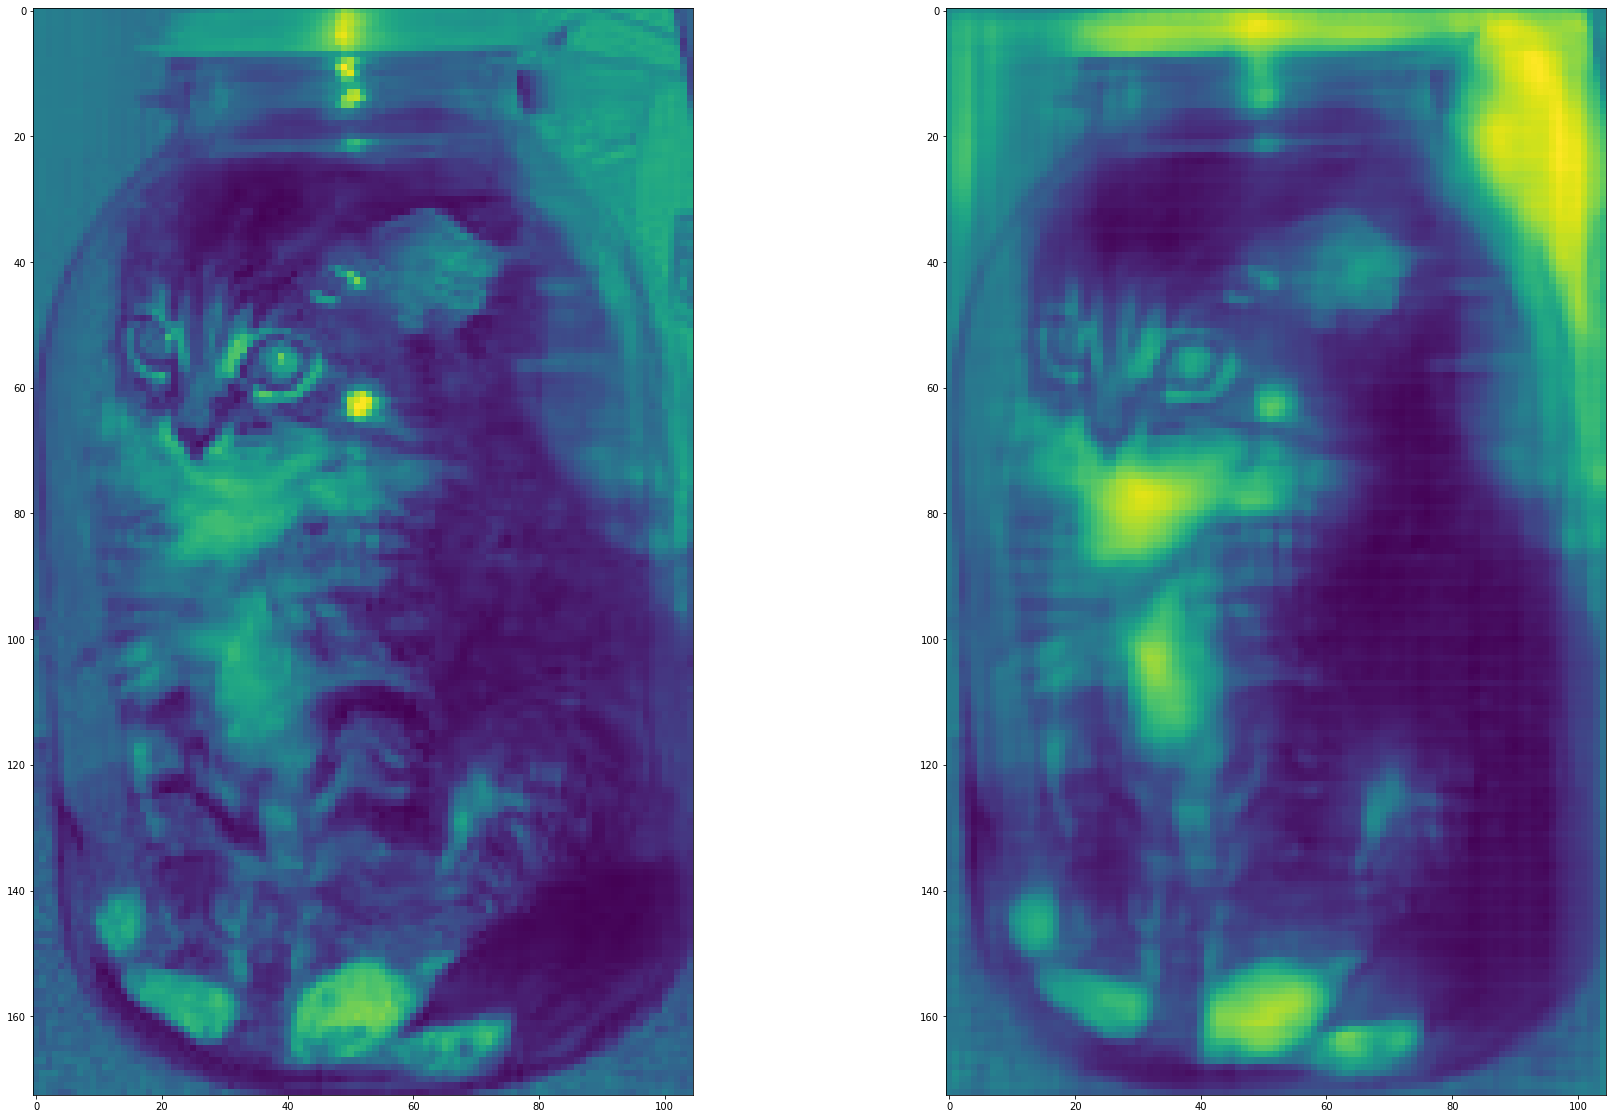

In [36]:
test_on_cats_and_blueprints('skips no sigmoid gaussian noise', Path() / 'learned_models' / 'autoencoder'/ '50epochs_1e-4_gauss_05.pt', no_sigmoid=True)

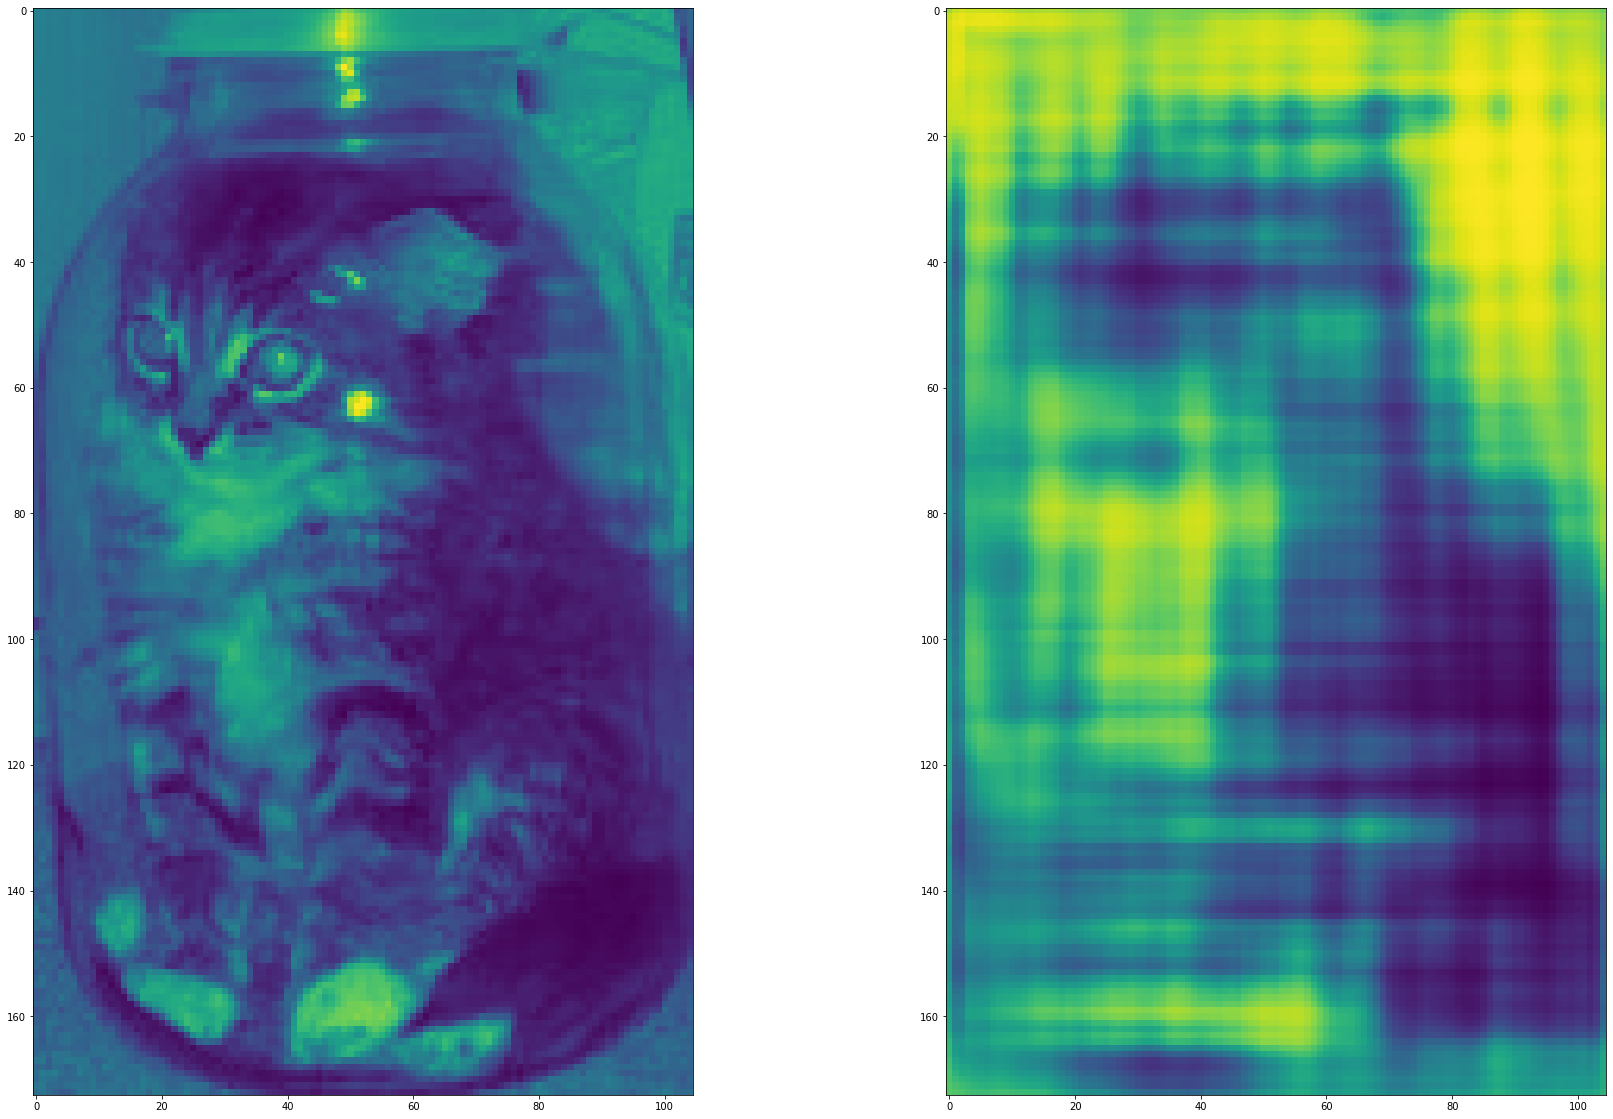

In [22]:
test_on_cats_and_blueprints('no_skips with sigmoid', Path() / 'learned_models' / '03_05' / 'autoencoder'/ '1e-4_50epochs_no_skip.pt', skip=SkipType.NO_SKIP)

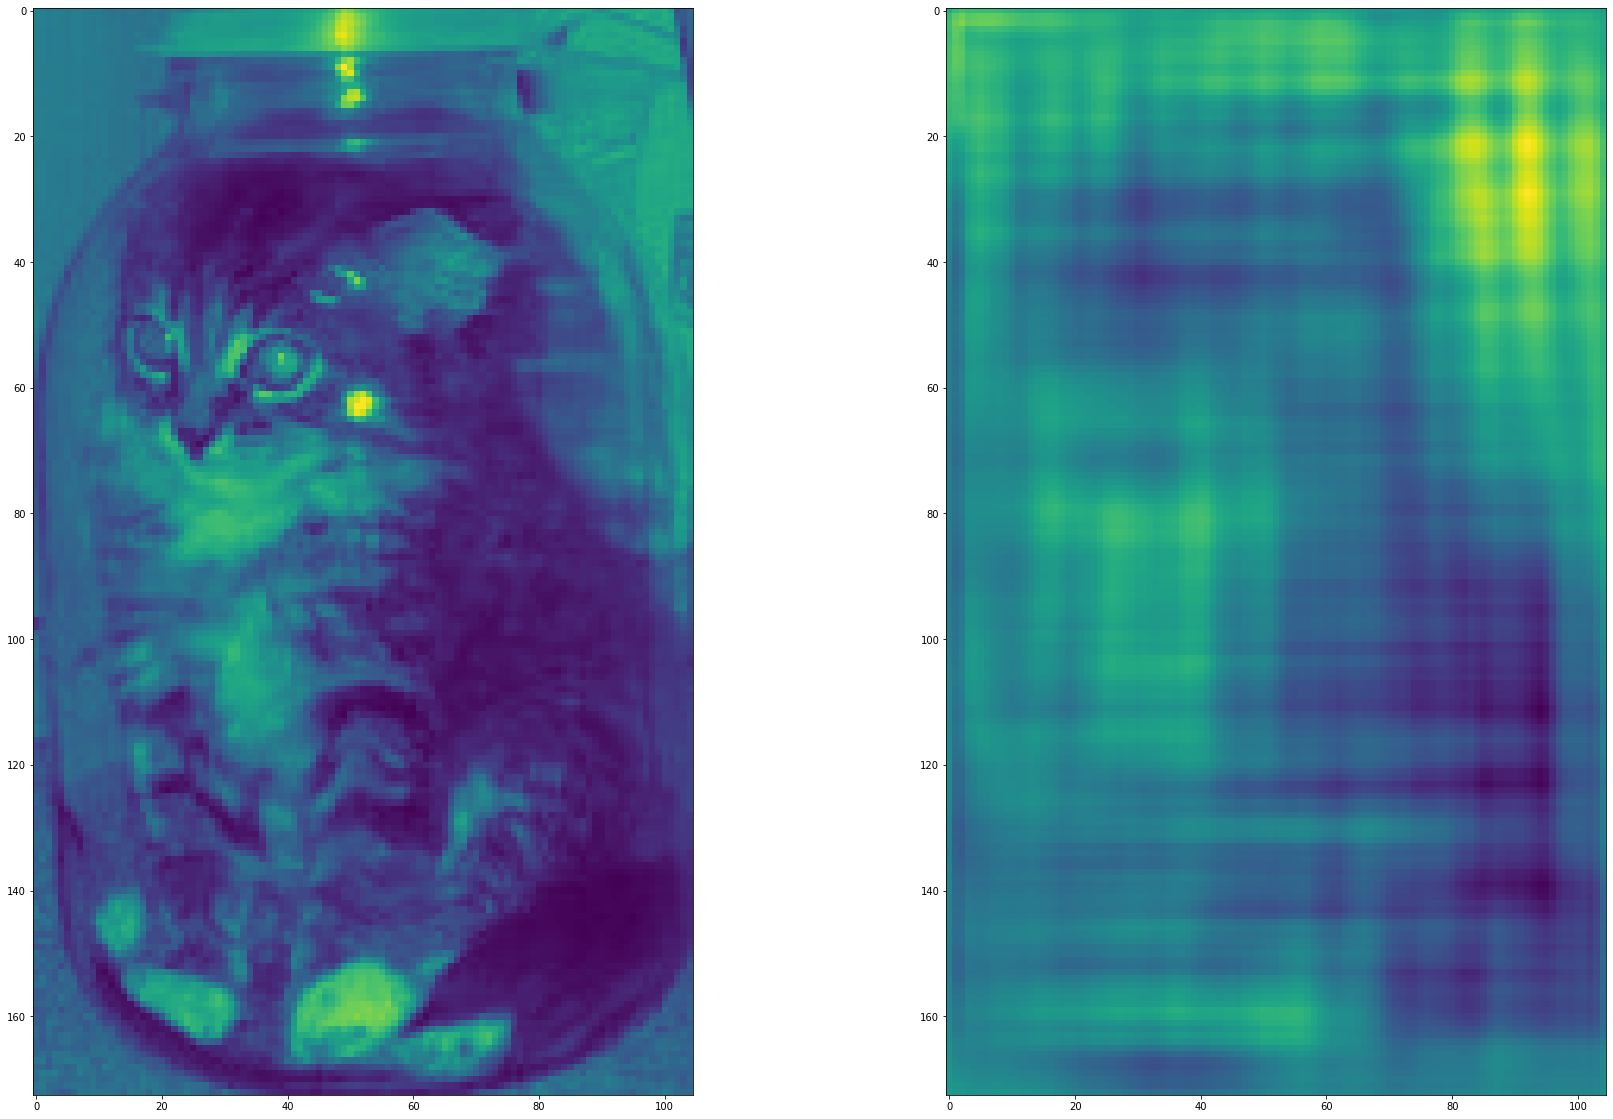

In [23]:
test_on_cats_and_blueprints('no_skips no sigmoid', Path() / 'learned_models' / '03_05' / 'autoencoder'/ '1e-4_50epochs_no_skip.pt', skip=SkipType.NO_SKIP, no_sigmoid=True)

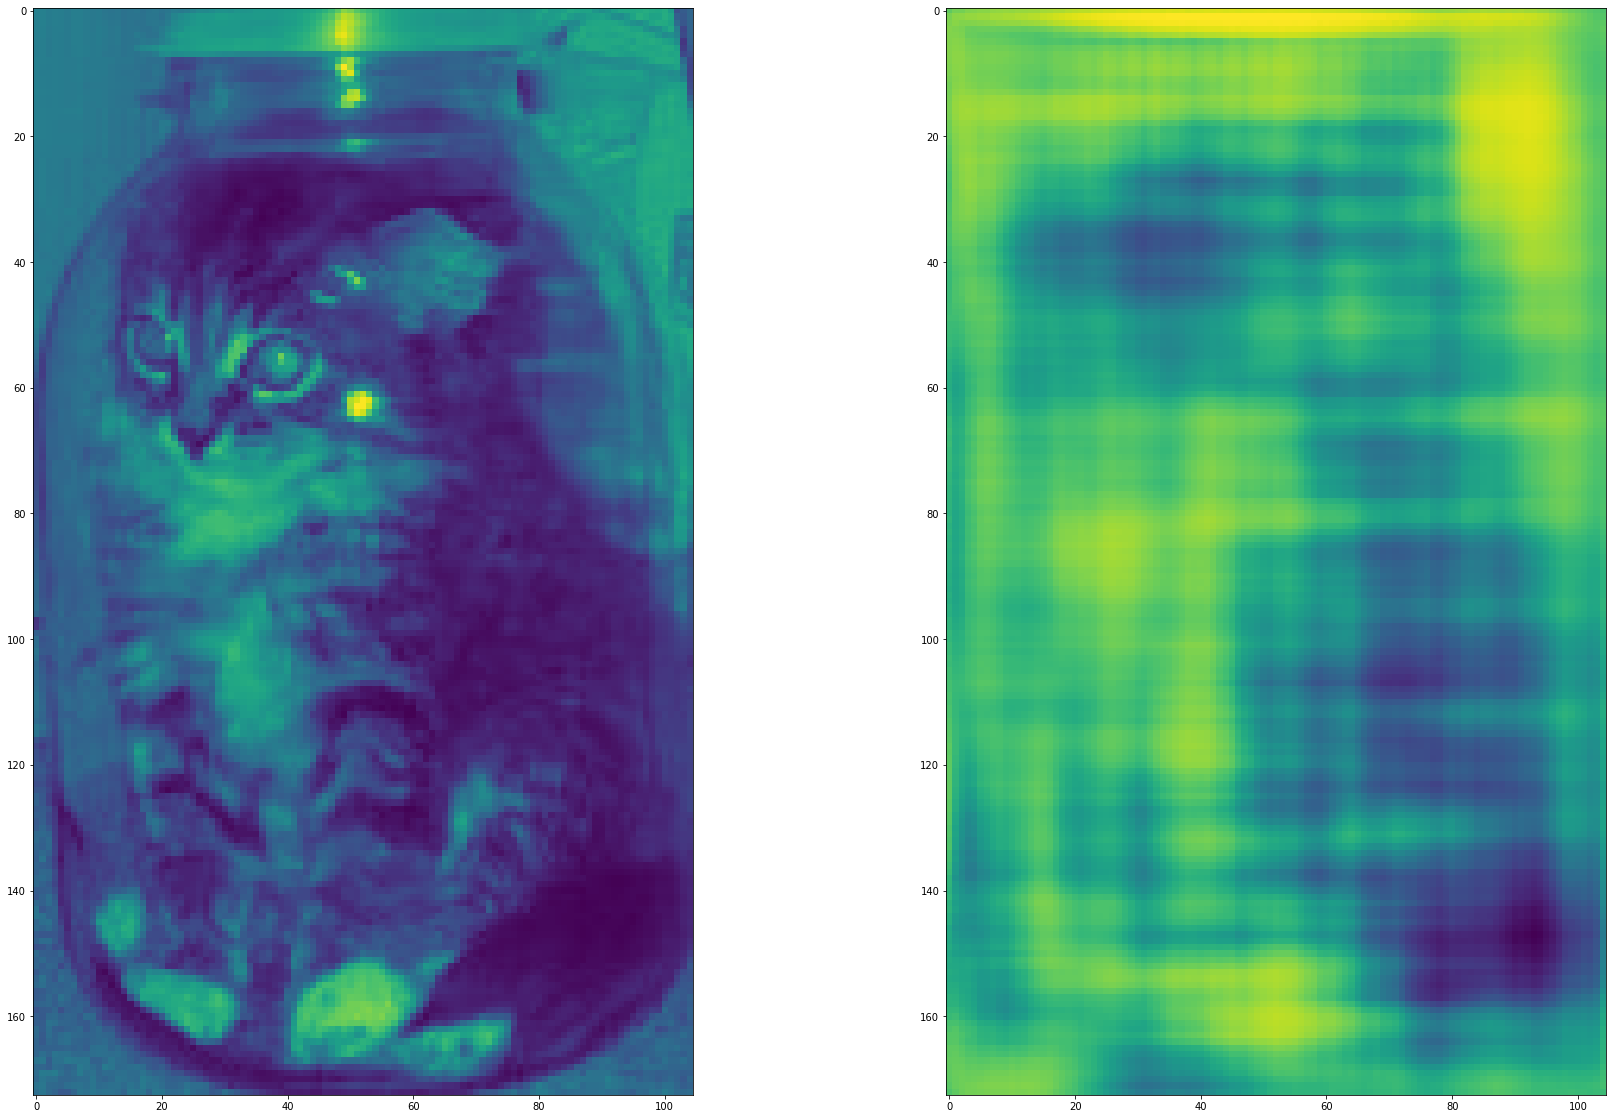

In [24]:
test_on_cats_and_blueprints('zero_skips with sigmoid', Path() / 'learned_models' / '03_05' / 'autoencoder'/ '1e-4_50epochs_zero_skip.pt')

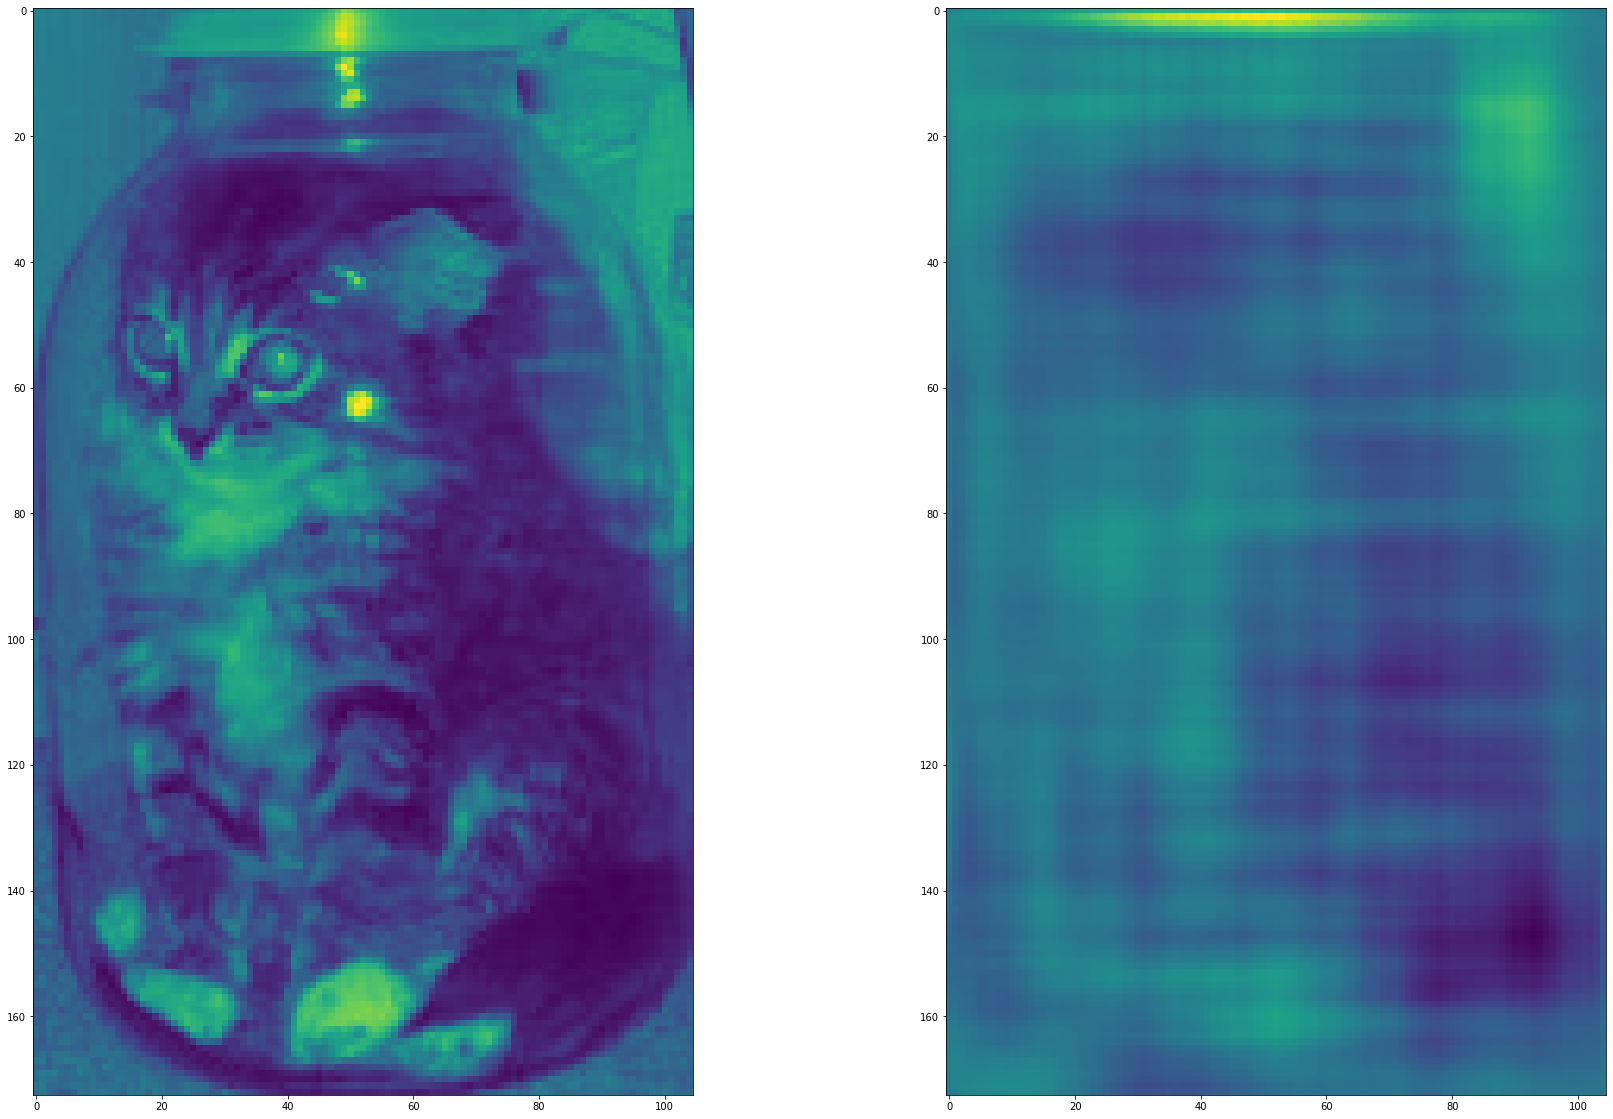

In [25]:
test_on_cats_and_blueprints('zero_skips no sigmoid', Path() / 'learned_models' / '03_05' / 'autoencoder'/ '1e-4_50epochs_zero_skip.pt', no_sigmoid=True)